In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.metrics.pairwise import haversine_distances
import pycountry

This is a preprocessing script for the earthquake data that will be modelled later using R. We study the earthquakes that are recorded on the USGS database since 1970, which had greater magnitude than 7.0. This data is downloaded from https://earthquake.usgs.gov/ and saved in a local csv file called ```earthquakes.csv```.

In [52]:
earthquakes = pd.read_csv('earthquakes.csv')
earthquakes = earthquakes[earthquakes['type'] == 'earthquake']

earthquakes['time'] = earthquakes['time'].str[:10]
earthquakes = earthquakes[['time', 'latitude', 'longitude', 'mag', 'place']]

## Clustering

Later, we will model the data using Poisson regression with a hierarchical structure. To this end, we want to group the incidents based on their geolocations (assuming that incidents that occured nearby are correlated). First, we take two different clustering approaches:

1. K-means not considering the geospatial distance 
2. DBSCAN with geospatial distance

Both algorithms work fine, but the distribution of the incidents may not be suitable for clustering. 

In [53]:
coords = earthquakes[['latitude', 'longitude']]

### K-means

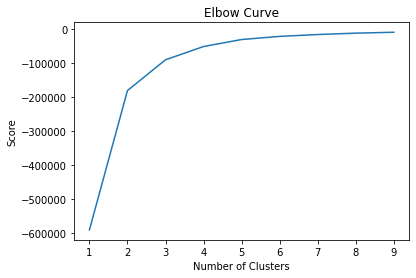

In [54]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = coords[['latitude']]
X_axis = coords[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [55]:
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(earthquakes[earthquakes.columns[1:3]])
earthquakes['cluster_label_kmean'] = kmeans.fit_predict(earthquakes[earthquakes.columns[1:3]])
centers = kmeans.cluster_centers_

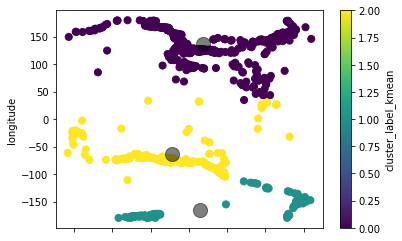

In [56]:
earthquakes.plot.scatter(x = 'latitude', y = 'longitude', c='cluster_label_kmean', s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### DBSCAN

In [57]:
kms_per_radian = 6371.0088
earth_diameter = 12742
epsilon = earth_diameter/ 7.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 13


In [58]:
earthquakes['cluster_label'] = cluster_labels

<Figure size 1200x1200 with 0 Axes>

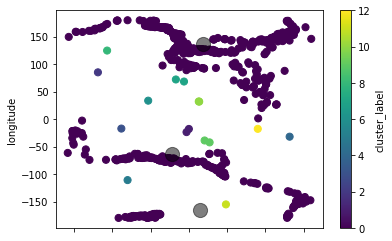

In [59]:
figure(figsize=(15, 15), dpi=80)
earthquakes.plot.scatter(x = 'latitude', y = 'longitude', c='cluster_label', s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

### Country

Since the grouping by clustering didn't work well as expected, we will extract country or state names from the field ```place```. If there is no country name in the field, the row will be discarded from the dataset.

In [60]:
state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", 
               "Colorado", "Connecticut", "District ", "of Columbia", "Delaware", "Florida", 
               "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", 
               "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", 
               "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", 
               "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", 
               "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", 
               "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", 
               "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

def extract_country(place: str):
    for country in pycountry.countries:
        if country.name in place:
            return country.name
        elif 'Russia' in place:
            return 'Russia'
        elif 'Taiwan' in place:
            return 'Taiwan'
        elif 'Venezuela' in place:
            return 'Venezuela'
        elif 'Iran' in place:
            return 'Iran'
        elif 'Bolivia' in place:
            return 'Bolivia'
    for state_name in state_names:
        if state_name in place:
            return 'USA'

In [61]:
earthquakes['country'] = earthquakes.apply(lambda row : extract_country(str(row['place'])), axis = 1)
earthquakes = earthquakes[earthquakes['country'].notnull()]
earthquakes.head()
#(earthquakes[earthquakes['country'].isnull()]).to_csv('_.csv', index=False)

,time,latitude,longitude,mag,place,cluster_label_kmean,cluster_label,country
1,2021-11-28,-4.4528,-76.8109,7.5,"44 km NNW of Barranca, Peru",2,0,Peru
2,2021-10-02,-21.1265,174.8958,7.3,Vanuatu region,0,0,Vanuatu
3,2021-09-08,16.9465,-99.7530,7.0,"Acapulco, Mexico",2,0,Mexico
5,2021-08-14,18.4335,-73.4822,7.2,"Nippes, Haiti",2,0,Haiti
8,2021-08-11,6.4748,126.7151,7.1,"60 km ENE of Pondaguitan, Philippines",0,0,Philippines


In [62]:
earthquakes[['time', 'latitude', 'longitude', 'mag', 'country']].to_csv('earthquakes_processed.csv', index = False)